In [13]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from IPython.display import Image, display
from typing import Literal, TypedDict, Annotated, List
import operator
import os

print("Successfully imported the neccessaries")


Successfully imported the neccessaries


In [2]:
load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("Load your key")

print("API key loaded")

API key loaded


In [3]:
llm =  ChatOpenAI(
    model = "gpt-5-nano",
    temperature = 0,
    api_key = api_key
)
print("Model has been  defined")

Model has been  defined


In [41]:
class critic_score(BaseModel):
    clarity: int 
    completeness: int 
    accuracy: int 
    explanation: str
    
print("Pydantic model ready for critic score") 

Pydantic model ready for critic score


In [42]:
# Defining our state

class Reflected(TypedDict):
    """The state of the reflection process"""
    query: str
    draft: str
    critique: str
    iterations: int
    critic_score: Annotated[List[critic_score], operator.add]
    final_output: str

MAX_REFLECTIONS = 3

print("Defined the state successfully")


Defined the state successfully


In [48]:
# the node to geenrate or refine the critiqued
def generate(state: Reflected) -> dict:
    """This is to generate or refine the critique"""
    if state["iterations"] == 0:
        # do the first generation
        prompt = f"""Create a response for the query:

    query: {state["query"]}
    Provide a clear and complete answer."""
        print("Generating...")

    else:
        # refine the critique
        prompt = f"""Improve this draft based on the critique:
        query: {state["query"]}

        current_draft: {state["draft"]}

        critique: {state["critique"]}
        
        create a more improved version of the draft"""
        print(f"Refining (iteration {state['iteration']})...")

    response = llm.invoke([HumanMessage(content=prompt)])

    print("Created draft")
    return {"draft": response.content}


# node to criticize
def criticize(state: Reflected) -> dict:
    """This is to evaluate the draft and provide a critique and scores"""

    structured_llm = llm.with_structured_output(critic_score)

    prompt = f"""Evaluate and constructively critique this draft based on the query:

    query: {state["query"]}

    draft: {state["draft"]}

    Provide a detailed critique and score it from 1-5 for clarity completeness and accuracy."""

    print("Critiquing draft ...")

    response = structured_llm.invoke([HumanMessage(content=prompt)])
    
    

    return {
        "critique": response,
        "iterations": state["iterations"] + 1
    }


# node to finalize

def finalize(state: Reflected) -> dict:
    """Set the final output """
    print("/n Reflection complete")
    return {
        "final_output": state["draft"]
    }

print("All nodes defined")



    


All nodes defined


In [ ]:
# the routing function 

def re_reflect(state: Reflected) -> Literal["generate", "finalize"]:
    "Deciding if to refine again"


    if state["iterations"] >= MAX_REFLECTIONS:
        print("Completed all iterations")
        return finalize

    last_score = state["critic_score"][-1]

    passed = (
        last_score.clarity >= 4 and 
        last_score.completeness >= 4 and 
        last_score.accuracy >= 4
    )

    if passed:
        print("All criteria has been met")
        return finalize

    
    return generate


print("Router ready")



Router ready


In [46]:
# let us build the graph

builder = StateGraph(Reflected)

builder.add_node("generate", generate)
builder.add_node("criticize", criticize)
builder.add_node("finalize", finalize)

builder.add_edge(START, "generate")
builder.add_edge("generate", "criticize")

builder.add_conditional_edges(
    "criticize",
    re_reflect,
    {"generate": "generate", "finalize": "finalize"}
)
builder.add_edge("finalize", END)

reflection_agent = builder.compile()

print("Created the agent for reflection")

Created the agent for reflection


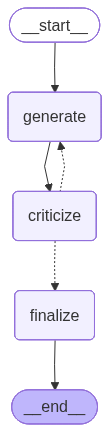

In [39]:
try:
    display(Image(reflection_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not get your image: {e}")

In [47]:
# let us try it out 

response = reflection_agent.invoke({
    "query": "What is meant by the term orthostatic hypotension?",
    "draft": "",
    'critique': "",
    "critic_score": [],
    "iterations": 0
})

print(f"\n{'='*70}")
print("📊 FINAL OUTPUT (after reflection):")
print(f"{'='*70}")
print(response["final_output"])
print(f"\nTotal iterations: {response['iterations']}")
print(f"{'='*70}\n")

Generating...
Created draft
Critiquing draft ...


IndexError: list index out of range